### Imports

In [1]:
import sys
import json
import matplotlib.pyplot as plt
import numpy as np

### Local imports

In [2]:
sys.path.insert(0,'src/')
from src.metrics import BinaryClassificationResult
from src.print_util import print_rates

### Functions

In [3]:
# Get the results of a single experiment, summed over the reruns and the configurations
def get_results_non_federated(all_results):
    result = BinaryClassificationResult()
    for configuration, configuration_results in all_results.items():      
        # Run can be a random rerun (when testing) or a fold (when grid searching)
        for run, run_result in enumerate(configuration_results):
            result += BinaryClassificationResult(*run_result.values())

    return result

In [4]:
# Get the results for each federation round of a single experiment, summed over the reruns and the configurations
def get_results_per_round(all_results):
    results_per_round = []
    for configuration, configuration_results in all_results.items():      
        # Run is the current random rerun
        for run, run_results in enumerate(configuration_results):
            for federation_round, round_results in enumerate(run_results):
                if federation_round >= len(results_per_round):
                    results_per_round.append(BinaryClassificationResult())  
                results_per_round[federation_round] += BinaryClassificationResult(*round_results.values())
                
    return results_per_round

In [5]:
# Get the results of a single experiment, summed over the reruns and the configurations
def get_thresholds_federated(all_thresholds):
    thresholds_sum = []
    n = 0
    for configuration, configuration_thresholds in all_thresholds.items():
        # Run can be a random rerun (when testing) or a fold (when grid searching)
        for run_thresholds in configuration_thresholds:
            n += 1
            for federation_round, round_threshold in enumerate(run_thresholds):
                if federation_round >= len(thresholds_sum):
                    thresholds_sum.append(0.)  
                thresholds_sum[federation_round] += round_threshold
    thresholds = [s / n for s in thresholds_sum]
                
    return thresholds

In [6]:
def plot_federated_tpr_tnr(results_to_plot, title=''):
    fig, ax1 = plt.subplots(figsize=(12, 5))
    ax1.set_xlabel('Federation round')

    color = 'blue'
    ax1.set_title(title)
    ax1.set_ylabel('TPR', color=color)
    ax1.plot([result.tpr() for result in results_to_plot], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.ticklabel_format(useOffset=False)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'red'
    ax2.set_ylabel('TNR', color=color)
    ax2.plot([result.tnr() for result in results_to_plot], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()

In [7]:
def plot_federated_acc(results_to_plot, title='', multi_epoch=True, save=False):
    fig, ax = plt.subplots(figsize=(12, 5))
    if multi_epoch:
        ax.set_xlabel('Federation round')
    else:
        ax.set_xlabel('Epoch')

    color = 'green'
    ax.set_title(title)
    ax.set_ylabel('Accuracy', color=color)
    ax.plot([result.acc() for result in results_to_plot], color=color)
    ax.tick_params(axis='y', labelcolor=color)
    ax.ticklabel_format(useOffset=False)
    ax.grid()
    plt.show()
    if save:
        fig.savefig('federated_accuracy' + ('_multi_epoch' if multi_epoch else '_mini_batch') + '.pdf', bbox_inches='tight')

In [8]:
def plot_global_thresholds(thresholds, title='', multi_epoch=True, save=False):
    fig, ax = plt.subplots(figsize=(6, 5))
    color = 'purple'
    ax.set_title(title)
    ax.set_ylabel('Threshold', color=color)
    
    if multi_epoch:
        ax.set_xlabel('Federation round')
        ax.plot(thresholds, color=color)
    else:
        ax.set_xlabel('Epoch')
        ax.set_xticks(np.arange(0, 120, step=10))
        ax.plot(np.arange(0,120, step=10), thresholds, color=color)

    ax.tick_params(axis='y', labelcolor=color)
    ax.ticklabel_format(useOffset=False)
    ax.grid()
    ax.set_ylim(ymin=0)
    plt.show()
    if save:
        fig.savefig('thresholds' + ('_multi_epoch' if multi_epoch else '_mini_batch') + '.pdf', bbox_inches='tight')

In [9]:
def percentage_str(value, bf=False):
    s = '{:.2f}\\%'.format(value * 100)
    if bf:
        s = '\\textbf{' + s + '}'
    return s

In [10]:
def print_rates_latex(results):
    print('Accuracy:\t' + percentage_str(results.acc(), bf=True))
    print('TPR:\t\t' + percentage_str(results.tpr()))
    print('TNR:\t\t' + percentage_str(results.tnr()))

In [11]:
def print_rates_latex2(results):
    print('Accuracy:\t' + percentage_str(results.acc()))
    print('TPR:\t\t' + percentage_str(results.tpr()))
    print('TNR:\t\t' + percentage_str(results.tnr()))
    print('F1-Score:\t' + percentage_str(results.f1()))

In [12]:
def get_average_threshold_non_federated(thresholds_dict):
    threshold_sum = 0.
    counter = 0
    for configuration, configuration_results in thresholds_dict.items():      
        # Run can be a random rerun (when testing) or a fold (when grid searching)
        for run, run_result in enumerate(configuration_results):
            counter += 1
            threshold_sum += run_result[0]
    return threshold_sum / counter

### Non-federated

In [13]:
path_test = 'test_results/decentralized_classifier/0,0787 5rr/'

with open(path_test + 'local_results.json') as json_file:
    test_local_results = json.load(json_file)
    
with open(path_test + 'new_devices_results.json') as json_file:
    test_new_results = json.load(json_file)
    
local_result = get_results_non_federated(test_local_results)
new_result = get_results_non_federated(test_new_results)
print('Local result:')
print_rates_latex(local_result)
print()

print('New result:')
print_rates_latex(new_result)

Local result:
Accuracy:	\textbf{99.78\%}
TPR:		99.98\%
TNR:		97.49\%

New result:
Accuracy:	\textbf{98.94\%}
TPR:		99.58\%
TNR:		91.44\%


### Threshold

In [14]:
path_test = 'test_results/decentralized_autoencoder/0,5 5rr mean+std/'

with open(path_test + 'thresholds.json') as json_file:
    thresholds = json.load(json_file)

avg_threshold = get_average_threshold_non_federated(thresholds)
print(avg_threshold)

1072714934.0549066


### Federated

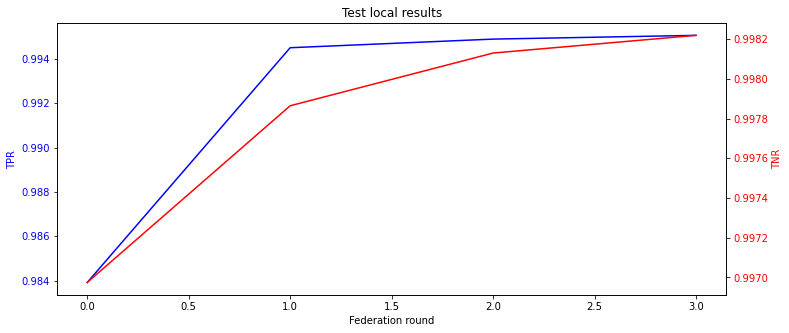

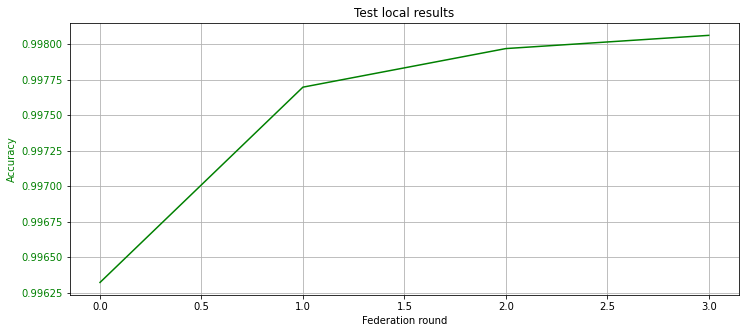

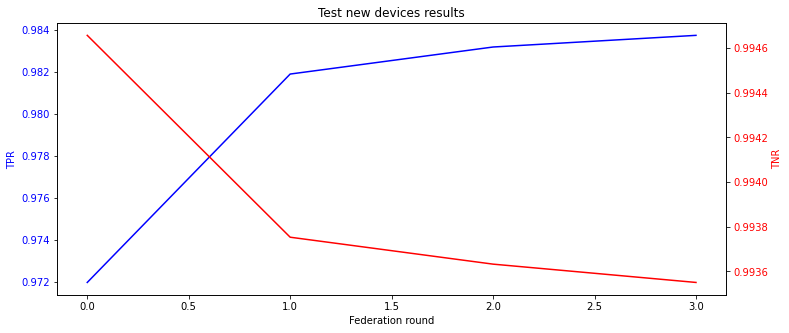

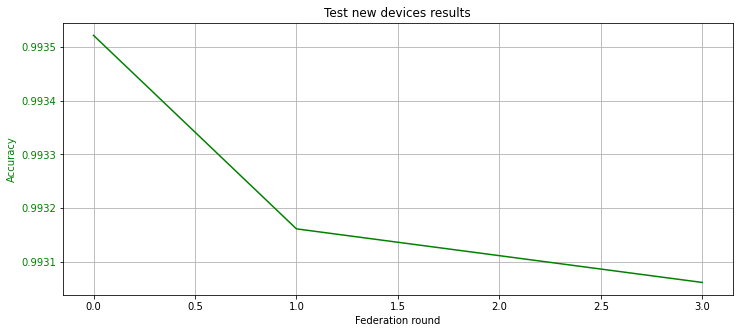

Local result at last round:
Accuracy:	99.81\%
TPR:		99.51\%
TNR:		99.82\%
F1-Score:	98.09\%

New result at last round:
Accuracy:	99.31\%
TPR:		98.38\%
TNR:		99.36\%
F1-Score:	93.41\%


In [15]:
# TODO: rename the x-axis as epoch in fedsgd and make it start at 1 in both cases

path_test = 'test_results/decentralized_classifier_fedsgd/NO_ATTACK/0,95 5rr 64bs tm2-2rs/'

with open(path_test + 'local_results.json') as json_file:
    test_local_results = json.load(json_file)
    
with open(path_test + 'new_devices_results.json') as json_file:
    test_new_results = json.load(json_file)
    
local_results_per_round = get_results_per_round(test_local_results)
plot_federated_tpr_tnr(local_results_per_round, title='Test local results')
plot_federated_acc(local_results_per_round, title='Test local results', multi_epoch=True)

new_results_per_round = get_results_per_round(test_new_results)
plot_federated_tpr_tnr(new_results_per_round, title='Test new devices results')
plot_federated_acc(new_results_per_round, title='Test new devices results')

print('Local result at last round:')
print_rates_latex2(local_results_per_round[-1])
print()

print('New result at last round:')
print_rates_latex2(new_results_per_round[-1])

In [16]:
def plot_federated_acc_2(res1, res2, res3, multi_epoch=True, save=False):
    fig, ax = plt.subplots(figsize=(6, 5))
    color1 = 'red'
    color2 = 'green'
    color3 = 'blue'
    
    ticks = list(np.arange(1, len(res1)+1))   
    
    if multi_epoch:
        ax.set_xlabel('Federation round')
        ax.set_xticks(ticks[::2])
    else:
        ax.set_xlabel('Epoch')
        ax.set_xticks(ticks)
    
    ax.grid()
        
    ax.set_ylabel('Accuracy')
    ax.plot(ticks,[result.acc() for result in res1], color=color1, label='7.87% benign')
    ax.plot(ticks,[result.acc() for result in res2], color=color2, label='50% benign')
    ax.plot(ticks,[result.acc() for result in res3], color=color3, label='95% benign')
    
    ax.hlines(0.9996, xmin=ticks[0], xmax=ticks[-1], color=color1, linestyles='dotted', label='7.87% benign (centralized)')
    ax.hlines(0.9991, xmin=ticks[0], xmax=ticks[-1], color=color2, linestyles='dotted', label='50% benign (centralized)')
    ax.hlines(0.9993, xmin=ticks[0], xmax=ticks[-1], color=color3, linestyles='dotted', label='95% benign (centralized)')

    
    ax.tick_params(axis='y')
    ax.ticklabel_format(useOffset=False)
    ax.legend()
    
    
    ax.set_ylim(0.992, 0.9997)
    ax.set_xlim(ticks[0], ticks[-1])
    plt.show()
    if save:
        fig.savefig('federated_accuracy' + ('_multi_epoch' if multi_epoch else '_mini_batch') + '.pdf', bbox_inches='tight')

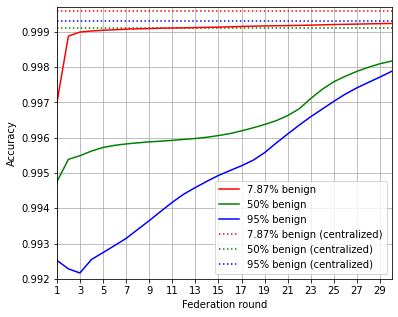

In [17]:
path_1 = 'test_results/decentralized_classifier_fedavg/0,0787 5rr/'
path_2 = 'test_results/decentralized_classifier_fedavg/0,5 5rr/'
path_3 = 'test_results/decentralized_classifier_fedavg/0,95 5rr/'

# path_1 = 'test_results/decentralized_classifier_fedsgd/NO_ATTACK/0,0787 5rr/'
# path_2 = 'test_results/decentralized_classifier_fedsgd/NO_ATTACK/0,5 5rr/'
# path_3 = 'test_results/decentralized_classifier_fedsgd/NO_ATTACK/0,95 5rr/'


with open(path_1 + 'local_results.json') as json_file:
    all_results_1 = json.load(json_file)

with open(path_2 + 'local_results.json') as json_file:
    all_results_2 = json.load(json_file)
    
with open(path_3 + 'local_results.json') as json_file:
    all_results_3 = json.load(json_file)
    
res1 = get_results_per_round(all_results_1)
res2 = get_results_per_round(all_results_2)
res3 = get_results_per_round(all_results_3)

plot_federated_acc_2(res1, res2, res3, multi_epoch=True, save=True)

In [41]:
def plot_global_thresholds_2(thresholds_1, multi_epoch=True, save=False):
    fig, ax = plt.subplots(figsize=(6, 5))
    color_1 = 'purple'
    color_2 = 'green'
    ax.set_ylabel('Threshold')
    ax.set_ylim(0, 0.0105)
    
    
    
    if multi_epoch:
        ticks = list(np.arange(1, len(thresholds_1)+1))
        ax.set_xlabel('Federation round')
        ax.set_xticks(ticks[::2])
    else:
        ax.set_xlabel('Epoch')
        ticks = list(np.arange(1, len(thresholds_1)*10+1, step=10))
        ax.set_xticks(ticks)
                
    
    if multi_epoch:
        label = "Multi-epoch averaging"
    else:
        label = "Mini-batch averaging"
    ax.plot(ticks, thresholds_1, color=color_1, label=label)
    
    ax.hlines(0.001566670167570313, xmin=ticks[0], xmax=ticks[-1], color=color_1, linestyles='dotted', label='Centralized')

    ax.set_xlim(ticks[0], ticks[-1])
    ax.tick_params(axis='y')
    ax.ticklabel_format(useOffset=False)
    ax.legend()
    ax.grid()
    plt.show()
    if save:
        fig.savefig('thresholds' + ('_multi_epoch' if multi_epoch else '_mini_batch') + '.pdf', bbox_inches='tight')

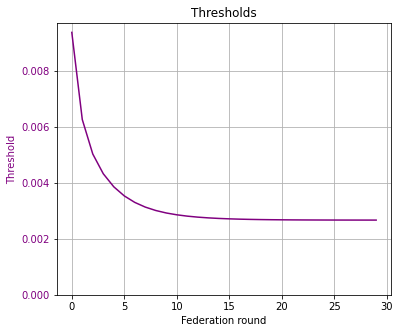

In [42]:
path_1 = 'test_results/decentralized_autoencoder_fedavg/0,5 5rr mean+std/'
with open(path_1 + 'thresholds.json') as json_file:
    all_thresholds_1 = json.load(json_file)


global_thresholds_1 = get_thresholds_federated(all_thresholds_1)
plot_global_thresholds(global_thresholds_1, 'Thresholds', multi_epoch=True, save=True)

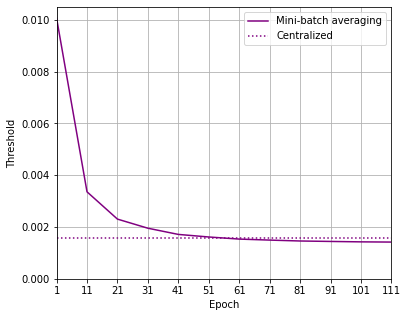

In [44]:
path_1 = 'test_results/decentralized_autoencoder_fedsgd/0,5 5rr mean+std/'

with open(path_1 + 'thresholds.json') as json_file:
    all_thresholds_1 = json.load(json_file)
    
global_thresholds_1 = get_thresholds_federated(all_thresholds_1)
plot_global_thresholds_2(global_thresholds_1, multi_epoch=False, save=True)

### Adversarial plots

In [21]:
b1 = BinaryClassificationResult(tp=45, tn=30, fp=20, fn=5)
b2 = BinaryClassificationResult(tp=3, tn=38, fp=12, fn=47)

In [22]:
b1.precision()

0.6923076923076923

In [23]:
b2.precision()

0.2

In [24]:
(b1+b2).precision()

0.6

In [25]:
(b1.precision() + b2.precision())/2

0.4461538461538461

In [26]:
def get_all_results(path):
    with open(path + 'local_results.json') as json_file:
        local_results = json.load(json_file)
    return local_results

In [27]:
def get_min_f1_last_round(all_results):
    min_f1 = 1.
    for configuration, configuration_results in all_results.items():      
        # Run is the current random rerun
        for run, run_results in enumerate(configuration_results):
            last_round_result = BinaryClassificationResult(**run_results[-1])
            if last_round_result.f1() < min_f1:
                min_f1 = last_round_result.f1()
                
    return min_f1

In [28]:
def get_max_f1_last_round(all_results):
    max_f1 = 0.
    for configuration, configuration_results in all_results.items():      
        # Run is the current random rerun
        for run, run_results in enumerate(configuration_results):
            last_round_result = BinaryClassificationResult(**run_results[-1])
            if last_round_result.f1() > max_f1:
                max_f1 = last_round_result.f1()
                
    return max_f1

In [29]:
def get_mean_f1_last_round(all_results):
    f1_sum = 0.
    counter = 0
    for configuration, configuration_results in all_results.items():      
        # Run is the current random rerun
        for run, run_results in enumerate(configuration_results):
            last_round_result = BinaryClassificationResult(**run_results[-1])
            f1_sum += last_round_result.f1()
            counter += 1
                
    return f1_sum / counter

In [30]:
def print_latex_f1_scores(base_path, end_path):
    avg_results = get_all_results(base_path + 'avg' + end_path)
    med_results = get_all_results(base_path + 'med' + end_path)
    tm1_results = get_all_results(base_path + 'tm1' + end_path)
    tm2_results = get_all_results(base_path + 'tm2' + end_path)
    tm2_2rs_results = get_all_results(base_path + 'tm2-2rs' + end_path)
    
    print('AVG:\t' + percentage_str(get_mean_f1_last_round(avg_results)))
    print('MED:\t' + percentage_str(get_mean_f1_last_round(med_results)))
    print('TM1:\t' + percentage_str(get_mean_f1_last_round(tm1_results)))
    print('TM2:\t' + percentage_str(get_mean_f1_last_round(tm2_results)))
    print('TM2-2RS:\t' + percentage_str(get_mean_f1_last_round(tm2_2rs_results)))

NameError: name 'thresholds_1' is not defined

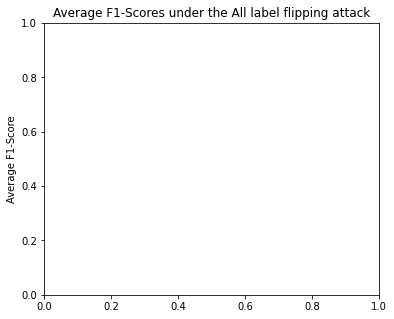

In [32]:
fig, ax = plt.subplots(figsize=(6, 5))
color_1 = 'gold'
color_2 = 'tab:orange'
color_3 = 'tab:red'
ax.set_title('Average F1-Scores under the All label flipping attack')
ax.set_ylabel('Average F1-Score')
ax.set_ylim(0, 1.0)

ax.plot(ticks, thresholds_1, color=color_1, label='mean + std')
ax.plot(ticks, thresholds_2, color=color_2, label='0.95 quantile')

ax.hlines(0.001566670167570313, xmin=ticks[0], xmax=ticks[-1], color=color_1, linestyles='dotted', label='mean + std (centralized)')
ax.hlines(0.0012821135499204198, xmin=ticks[0], xmax=ticks[-1], color=color_2, linestyles='dotted', label='0.95 quantile (centralized)')

ax.set_xlim(ticks[0], ticks[-1])
ax.tick_params(axis='y')
ax.ticklabel_format(useOffset=False)
ax.legend()
ax.grid()
plt.show()
if save:
    fig.savefig('thresholds' + ('_multi_epoch' if multi_epoch else '_mini_batch') + '.pdf', bbox_inches='tight')

In [165]:
def plot_f1_scores(base_path, end_path, attack_str):
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.set_title('Average, min and max F1-Scores under the ' +  attack_str + ' attack')
    ax.set_ylabel('F1-Score')
    ax.set_ylim(0, 1.)
    
    pos_x = 0
    colors = ['limegreen', 'gold', 'tab:orange', 'orangered']
    colors = ['#87d64b', '#fae243', '#f8961e', '#ff4d36']
    
    aggs = ['avg', 'med', 'tm1', 'tm2', 'tm2-2rs']
    
    for agg in aggs:
        for f in [0, 1, 2, 3]:
            color = colors[f]
            if f == 0:
                results = get_all_results('test_results/decentralized_classifier_fedsgd/NO_ATTACK/0,95 5rr 64bs ' + agg + '/')
            else:
                results = get_all_results(base_path + agg + ' vs ' + repr(f) + end_path)
            mean_f1 = get_mean_f1_last_round(results)
            if mean_f1 == 0.0:
                mean_f1 = 0.01
            min_f1 = get_min_f1_last_round(results)
            max_f1 = get_max_f1_last_round(results)
            
            yerr_up = max_f1 - mean_f1
            yerr_down = mean_f1 - min_f1
            
            if agg == 'avg':
                ax.bar(pos_x, height=mean_f1, color=color, width=1, lw=0.7, edgecolor='black', label='f='+repr(f))
            else:
                ax.bar(pos_x, height=mean_f1, color=color, width=1, lw=0.7, edgecolor='black') # yerr=[[yerr_down], [yerr_up]], capsize=11
                
            ax.errorbar(x=pos_x, y=mean_f1, yerr=[[yerr_down], [yerr_up]],
                        capsize=5, color='black', elinewidth=0, lw=0.7, solid_capstyle='round')
            pos_x += 1
        pos_x += 1.5
    
    ax.set_xticks([1.5, 7, 12.5, 18, 23.5])
    aggs = [agg.upper() for agg in aggs]
    ax.set_xticklabels(aggs, rotation='vertical')
    ax.legend(bbox_to_anchor=(1.16, 0.5), loc='right')
    plt.show()
    fig.savefig('f1_scores_' + '_'.join(attack_str.split(' ')) + '.pdf', bbox_inches='tight')

In [166]:
plt.rcParams.update({'font.size': 16.5})

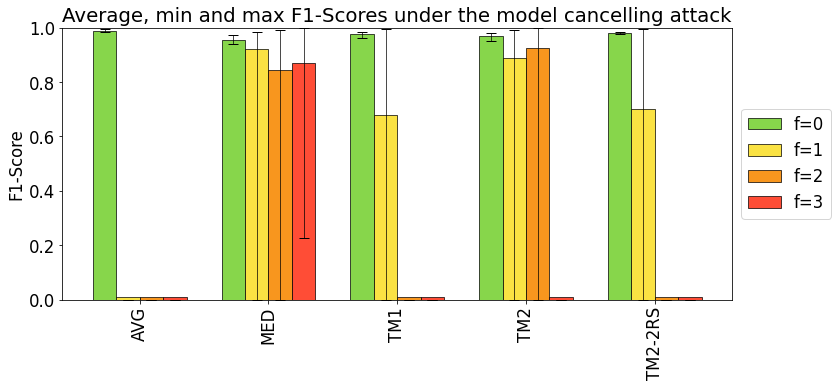

In [170]:
attack_folder = 'CANCEL'
attack_code = 'cancel/'
attack_name = 'model cancelling'

# attack_folder = 'GRADIENT_FACTOR'
# attack_code = 'factor/'
# attack_name = 'gradient factor'

# attack_folder = 'CANCEL'
# attack_code = 'cancel/'
# attack_name = 'model cancelling'

plot_f1_scores('test_results/decentralized_classifier_fedsgd/' + attack_folder + '/', attack_code, attack_name)

In [47]:
print_latex_f1_scores('test_results/decentralized_classifier_fedsgd/CANCEL/', ' vs 3cancel/')

AVG:	0.00\%
MED:	87.09\%
TM1:	0.00\%
TM2:	0.00\%
TM2-2RS:	0.00\%


In [48]:
get_mean_f1_last_round(get_all_results('avg vs 1flipping/'))

FileNotFoundError: [Errno 2] No such file or directory: 'avg vs 1flipping/local_results.json'

In [49]:
path_1_1 = base_path + 'avg vs 1flipping/'
path_1_2 = base_path + 'avg vs 2flipping/'
path_1_3 = base_path + 'avg vs 3flipping/'

path_2_1 = base_path + 'med vs 1flipping/'
path_2_2 = base_path + 'med vs 2flipping/'
path_2_3 = base_path + 'med vs 3flipping/'

path_3_1 = base_path + 'tm1 vs 1flipping/'
path_3_2 = base_path + 'tm1 vs 2flipping/'
path_3_3 = base_path + 'tm1 vs 3flipping/'

path_4_1 = base_path + 'tm2 vs 1flipping/'
path_4_2 = base_path + 'tm2 vs 2flipping/'
path_4_3 = base_path + 'tm2 vs 3flipping/'

path_5_1 = base_path + 'tm2-2rs vs 1flipping/'
path_5_2 = base_path + 'tm2-2rs vs 2flipping/'
path_5_3 = base_path + 'tm2-2rs vs 3flipping/'

with open(path_test + 'local_results.json') as json_file:
    test_local_results = json.load(json_file)
    
local_results_per_round = get_results_per_round(test_local_results)
plot_federated_tpr_tnr(local_results_per_round, title='Test local results')
plot_federated_acc(local_results_per_round, title='Test local results', multi_epoch=True)

print('Local result at last round:')
print_rates_latex(local_results_per_round[-1])
print()

def plot_global_thresholds_2(thresholds_1, thresholds_2, title='', multi_epoch=True, save=False):
    fig, ax = plt.subplots(figsize=(6, 5))
    color_1 = 'purple'
    color_2 = 'green'
    ax.set_title(title)
    ax.set_ylabel('Threshold')
    ax.set_ylim(0, 0.0105)
    
    
    
    if multi_epoch:
        ticks = list(np.arange(1, len(thresholds_1)+1))
        ax.set_xlabel('Federation round')
        ax.set_xticks(ticks[::2])
    else:
        ax.set_xlabel('Epoch')
        ticks = list(np.arange(1, len(thresholds_1)*10+1, step=10))
        ax.set_xticks(ticks)
                
    
        
    ax.plot(ticks, thresholds_1, color=color_1, label='mean + std')
    ax.plot(ticks, thresholds_2, color=color_2, label='0.95 quantile')
    
    ax.hlines(0.001566670167570313, xmin=ticks[0], xmax=ticks[-1], color=color_1, linestyles='dotted', label='mean + std (centralized)')
    ax.hlines(0.0012821135499204198, xmin=ticks[0], xmax=ticks[-1], color=color_2, linestyles='dotted', label='0.95 quantile (centralized)')

    ax.set_xlim(ticks[0], ticks[-1])
    ax.tick_params(axis='y')
    ax.ticklabel_format(useOffset=False)
    ax.legend()
    ax.grid()
    plt.show()
    if save:
        fig.savefig('thresholds' + ('_multi_epoch' if multi_epoch else '_mini_batch') + '.pdf', bbox_inches='tight')

NameError: name 'base_path' is not defined

These plots are interesting but could be improved with confidence intervals.